In [12]:
import pandas as pd
import numpy as np

# Load and clean the original dataset again
data = pd.read_csv('../data/raw/MachineLearningRating_v3.txt', sep='|', low_memory=False)


In [13]:
# Convert numeric fields
data['TotalClaims'] = pd.to_numeric(data['TotalClaims'], errors='coerce')
data['TotalPremium'] = pd.to_numeric(data['TotalPremium'], errors='coerce')

print("Total rows:", data.shape[0])
print("Rows with non-zero TotalClaims:", (data['TotalClaims'] > 0).sum())
print("Rows with TotalPremium > 0:", (data['TotalPremium'] > 0).sum())

print(data['TotalClaims'].unique()[:20])  # preview first 20 unique values
print(data['TotalClaims'].dtype)

Total rows: 1000098
Rows with non-zero TotalClaims: 2788
Rows with TotalPremium > 0: 618176
[    0.          2294.09649123  2040.47368421 46492.21175439
 26516.85964912  6140.35087719  4385.96491228 25438.59649123
 16715.         74967.01754386 14867.5         2192.98245614
  1450.           921.05263158 16804.46491228  2889.70175439
   877.19298246 15262.60526316 72445.03508772  5263.15789474]
float64


In [14]:
# STEP 1: Filter only claim records
claims_df = data[(data['TotalClaims'] > 0) & (data['TotalPremium'] > 0)].copy()



In [15]:
# STEP 2: Drop irrelevant/high-cardinality columns
drop_cols = [
    'UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'VehicleIntroDate',
    'Model', 'Make', 'MainCrestaZone', 'SubCrestaZone',
    'Product', 'Section', 'StatutoryClass', 'StatutoryRiskType'
]
claims_df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [16]:
# STEP 3: Encode categorical features using one-hot encoding
categorical_cols = claims_df.select_dtypes(include='object').columns
claims_df = pd.get_dummies(claims_df, columns=categorical_cols, drop_first=True)

In [17]:
# STEP 4: Drop remaining NaNs just to be safe
# Only drop rows where target or numeric inputs are invalid
required_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'CustomValueEstimate']
claims_df = claims_df.dropna(subset=required_cols)

print(f"✅ After cleanup: {claims_df.shape[0]} rows")


✅ After cleanup: 632 rows


In [18]:
# STEP 5: Split features and target
X = claims_df.drop(columns=['TotalClaims'])
y = claims_df['TotalClaims']

print(f"✅ Ready for modeling: {X.shape[0]} records, {X.shape[1]} features")

✅ Ready for modeling: 632 records, 304 features


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.4f}")


📊 RMSE: 46149.18
📈 R² Score: 0.1874


/var/folders/pp/3nx806hs7bl388g7c6clvc5h0000gn/T/ipykernel_12946/2373806289.py:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/oza/Developer/10 Acadamy/week3/insurance-risk-analytics/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


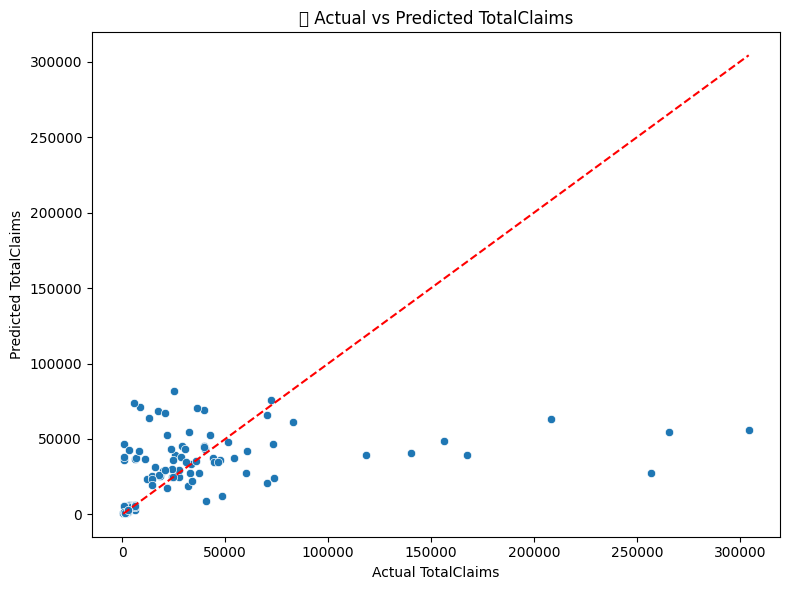

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual TotalClaims")
plt.ylabel("Predicted TotalClaims")
plt.title("📈 Actual vs Predicted TotalClaims")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.tight_layout()
plt.show()
